# __`scikit-learn`-style API__

In [1]:
import adelie as ad
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

np.random.seed(42)

## __Regression__

In [2]:
from sklearn.datasets import load_diabetes

Scikit regression data for testing

In [3]:
data = load_diabetes()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, y_train.shape, X_test.shape,  y_test.shape

((353, 10), (353,), (89, 10), (89,))

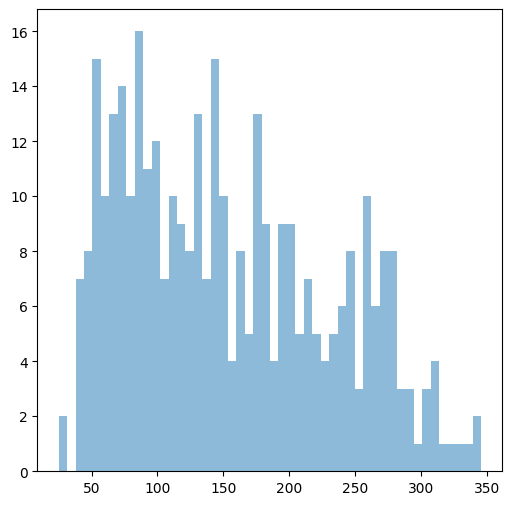

In [4]:
f, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.hist(y_train, bins=50, alpha=0.5, label='train');

## __Lasso__

Instantiate a `GroupElasticNet` class 

In [5]:
lam_path = np.logspace(-10, 10, 100)
m0 = ad.GroupElasticNet(solver="grpnet")
m0.fit(X_train, y_train, lmda_path=lam_path)  # fit
yhatmat = m0.predict(
    X_test
)  # predict - produces a matrix of predictions where each row is the prediction vector for a given lambda
print(yhatmat.shape)

/home/alal/Desktop/forks/adelie/adelie/matrix.py:437: UserWarning: Detected matrix to be C-contiguous. Performance may improve with F-contiguous matrix.
  warnings.warn(
100%|██████████| 100/100 [00:00:00<00:00:00, 27095.49it/s] [dev:52.8%]


(100, 89)


Compute out-of-sample R-squared for each $\lambda$ value

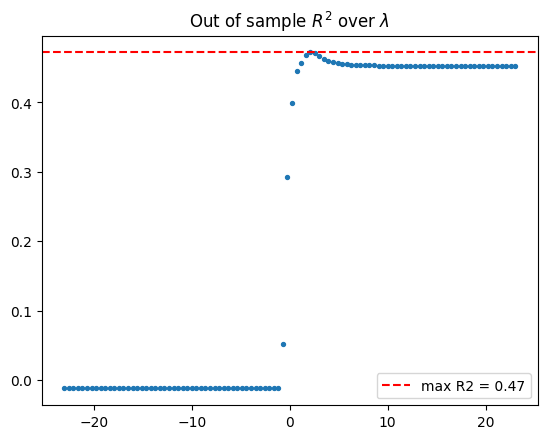

In [6]:
r2vec = np.apply_along_axis(lambda yhat: r2_score(y_test, yhat), axis=1, arr=yhatmat)
plt.scatter(np.log(lam_path), r2vec, s = 8)
plt.axhline(r2vec.max(), color="red", linestyle="--", label=f"max R2 = {r2vec.max():.2f}")
plt.legend()
plt.title(r"Out of sample $R^2$ over $\lambda$");

## __basic cross-validation : `cv_grpnet` solver__

when the model class is initalized with `cv_grpnet`, we select the best lambda by cross-validation and return the corresponding model.

In [7]:
m = ad.GroupElasticNet(solver="cv_grpnet")
m.fit(X_train, y_train, lmda_path_size=1_000, min_ratio=1e-3)

/home/alal/Desktop/forks/adelie/adelie/matrix.py:437: UserWarning: Detected matrix to be C-contiguous. Performance may improve with F-contiguous matrix.
  warnings.warn(
100%|██████████| 1003/1003 [00:00:00<00:00:00, 83366.25it/s] [dev:51.8%]


100%|██████████| 1/1 [00:00:00<00:00:00, 1058.85it/s] [dev:52.6%]


GroupElasticNet(solver='cv_grpnet')

With the `cv_grpnet` backend, calling predict automatically uses the model with the best lambda.

In [8]:
m.predict(X_test).shape

(89,)

The class also has a score method that computes r-squared. 

In [9]:
m.score(X_test, y_test)

0.45678584045740367

## __Logistic Regression__

In [10]:
from sklearn.datasets import load_breast_cancer
import scipy.stats as st

In [11]:
data = load_breast_cancer()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((455, 30), (455,), (114, 30), (114,))

In [12]:
m0 = ad.GroupElasticNet(solver="cv_grpnet", family="binomial")
m0.fit(X_train, y_train.astype(np.float64))


100%|██████████| 1/1 [00:00:00<00:00:00, 1151.99it/s] [dev:63.3%]


GroupElasticNet(family='binomial', solver='cv_grpnet')

In [13]:
yhat = m0.predict(X_test)
st.contingency.crosstab(y_test, yhat).count

array([[28, 16],
       [ 0, 70]])

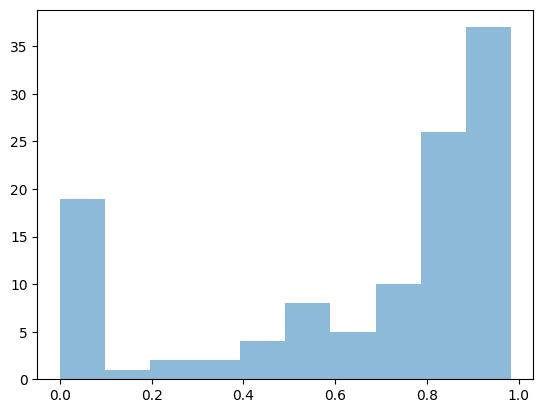

In [14]:
plt.hist(m0.predict_proba(X_test)[:, 1], alpha = 0.5);

## __Multinomial Logit__

In [15]:
from sklearn.datasets import load_digits
from sklearn.preprocessing import OneHotEncoder

In [16]:
data = load_digits()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# one-hot-encode labels
oh = OneHotEncoder(sparse_output=False)
y_train2 = oh.fit_transform(y_train[:, np.newaxis])
X_train.shape, y_train.shape, y_train2.shape, X_test.shape, y_test.shape

((1437, 64), (1437,), (1437, 10), (360, 64), (360,))

In [17]:
m0 = ad.GroupElasticNet(solver="cv_grpnet", family="multinomial")
m0.fit(X_train, y_train2.astype(np.float64))


/home/alal/Desktop/forks/adelie/adelie/matrix.py:437: UserWarning: Detected matrix to be C-contiguous. Performance may improve with F-contiguous matrix.
  warnings.warn(


100%|██████████| 1/1 [00:00:00<00:00:00, 1.55it/s] [dev:84.6%]


GroupElasticNet(family='multinomial', solver='cv_grpnet')

In [18]:
yhat = m0.predict(X_test)
st.contingency.crosstab(y_test, yhat).count

array([[29,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 32,  0,  0,  0,  0,  0,  0,  2,  2],
       [ 0,  0, 41,  1,  0,  0,  0,  0,  0,  1],
       [ 0,  1,  0, 34,  0,  0,  0,  0,  1,  0],
       [ 0,  1,  0,  0, 37,  0,  0,  1,  0,  1],
       [ 0,  0,  0,  0,  0, 37,  0,  0,  0,  3],
       [ 0,  1,  0,  0,  0,  0, 37,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0, 31,  0,  0],
       [ 0,  3,  0,  1,  0,  2,  0,  2, 23,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1,  0, 34]])